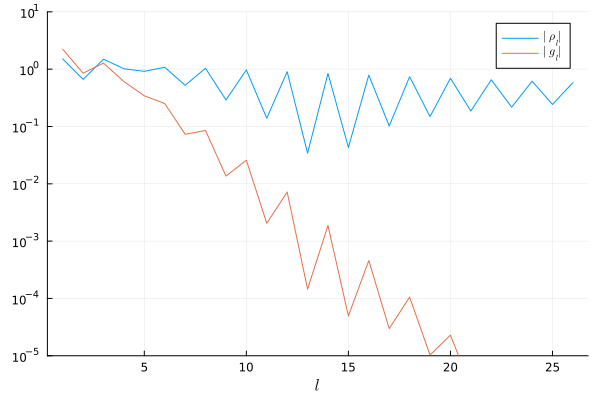

In [1]:
using Revise
ENV["SPARSEIR_LIB_PATH"] = "/Users/hiroshi/opt/libsparseir/lib/libsparseir.0.5.2.dylib"
using SparseIR
using Plots
gr() # USE GR backend
using OMEinsum
using LaTeXStrings

beta = 15.0
wmax = 10.0
basis_b = FiniteTempBasis(Bosonic(), beta, wmax, 1e-7)

coeff = [1.0]
omega_p = [0.1]

rhol_pole = ein"lp,p->l"(
    basis_b.v(omega_p),
    coeff ./ tanh.(0.5*beta*omega_p)
)
gl_pole = - basis_b.s .* rhol_pole

plot([abs.(rhol_pole), abs.(gl_pole)], yaxis=:log, label=[latexstring("|\\rho_l|") latexstring("|g_l|")], xlabel=latexstring("l"), ylims=(1e-5, 1e+1))

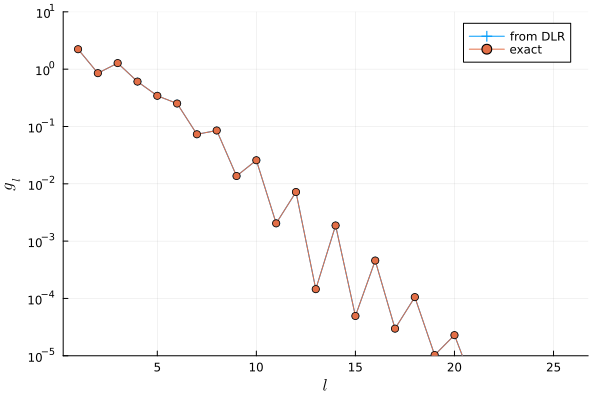

In [2]:
dlr = DiscreteLehmannRepresentation(basis_b, omega_p)
gl_pole2 = SparseIR.to_IR(dlr, coeff ./ tanh.(0.5*beta*omega_p))

plot(
    [abs.(gl_pole2), abs.(gl_pole)],
    label=["from DLR" "exact"],
    yaxis=:log,
    xlabel=latexstring("l"), ylabel=latexstring("g_l"), ylims=(1e-5, 1e+1), marker=[:cross :circle])

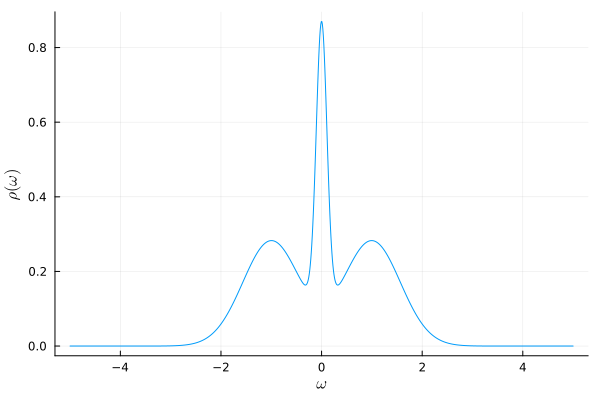

In [3]:
# Three Gaussian peaks (normalized to 1)
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)

rho(omega) = 0.2*gaussian(omega, 0.0, 0.15) + 
    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

omegas = LinRange(-5, 5, 1000)
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"), label="")

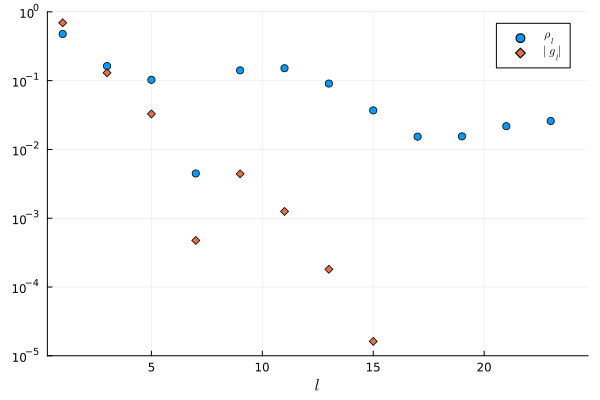

In [4]:
beta = 10.0
wmax = 10.0
basis = FiniteTempBasis(Fermionic(), beta, wmax, 1e-7)

rhol = [overlap(basis.v[l], rho, -wmax, wmax) for l in 1:length(basis)]
gl = - basis.s .* rhol

plot([abs.(rhol), abs.(gl)], yaxis=:log, ylims=(1e-5,1), marker=[:circle :diamond], line=nothing, xlabel=latexstring("l"), label=[latexstring("\\rho_l") latexstring("|g_l|")])

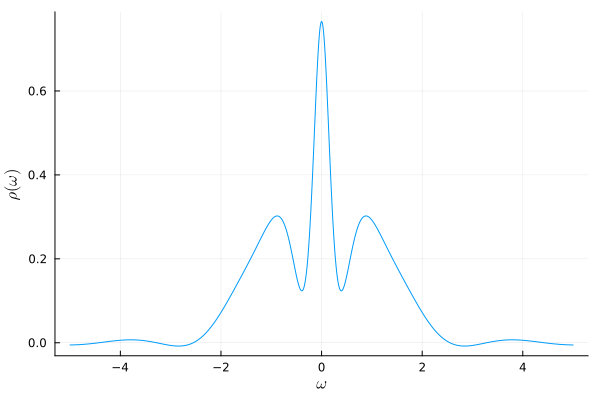

In [5]:
rho_omega_reconst = transpose(basis.v(omegas)) * rhol

plot(omegas, rho_omega_reconst, xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"), label="")

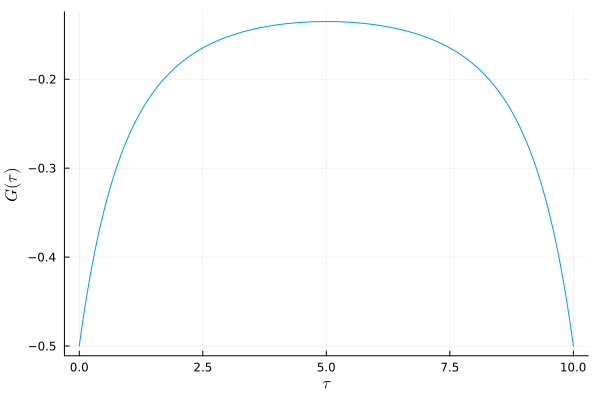

In [6]:
taus = collect(LinRange(0, beta, 1000))
gtau1 = transpose(basis.u(taus)) * gl

plot(taus, gtau1, xlabel=latexstring("\\tau"), ylabel=latexstring("G(\\tau)"), label=nothing)

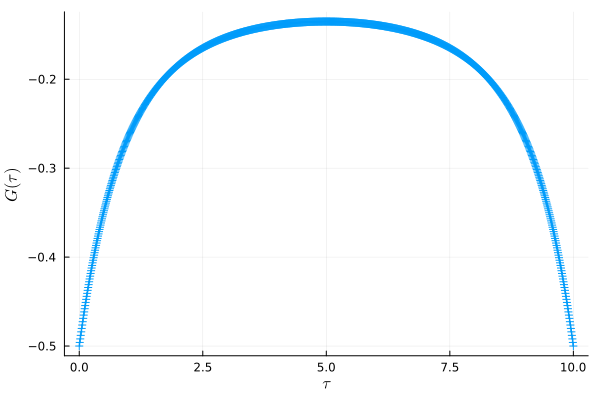

In [7]:
smpl = TauSampling(basis; sampling_points=taus)
gtau2 = evaluate(smpl, gl)
plot(taus, gtau2, xlabel=latexstring("\\tau"), ylabel=latexstring("G(\\tau)"), label=nothing, marker=:cross)

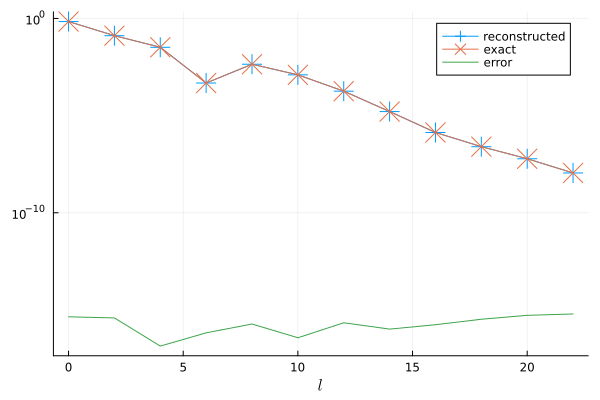

In [8]:
function eval_gtau(taus)
    uval = basis.u(taus) #(nl, ntau)
    return transpose(uval) * gl
end

gl_reconst = [overlap(basis.u[l], eval_gtau, 0.0, beta) for l in 1:length(basis)]

ls = collect(0:length(basis)-1)
plot(
    ls[1:2:end],
    [abs.(gl_reconst[1:2:end]), abs.(gl[1:2:end]), abs.(gl_reconst - gl)[1:2:end]], xlabel=latexstring("l"), label=["reconstructed" "exact" "error"], marker=[:+ :x :none], markersize=10, yaxis=:log)

In [9]:
using Random
rng = Xoshiro(100)
shape = (1,2,3)
newaxis = [CartesianIndex()]
gl_tensor = randn(rng, shape...)[:,:,:, newaxis] .* gl[newaxis,newaxis,newaxis, :]
println("gl: ", size(gl))
println("gl_tensor: ", size(gl_tensor))

gl: (

24,)
gl_tensor: (1, 2, 3, 24)


In [10]:
smpl_matsu = MatsubaraSampling(basis)
gtau_tensor = evaluate(smpl_matsu, gl_tensor, dim=4)
print("gtau_tensor: ", size(gtau_tensor))
gl_tensor_reconst = fit(smpl_matsu, gtau_tensor, dim=4)
@assert isapprox(gl_tensor, gl_tensor_reconst)

gtau_tensor: (

1, 2, 3, 24)